In [1]:
# Training a small convnet from scratch to classify a single binary label (e.g. agriculture)
# See: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from datetime import datetime
import time

timestr = time.strftime("%Y%m%d-%H%M%S")
startTime = datetime.now()

Using Theano backend.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
c:\users\me\appdata\local\temp\try_flags_fkvhp1.c:4:19: fatal error: cudnn.h: No such file or directory
compilation terminated.

Mapped name None to device cuda: GeForce GTX 1060 6GB (0000:01:00.0)


In [2]:
data_dir = 'D:/Downloads/amazon/'
target_label = 'agriculture'
num_samples_per_epoch = 10000
# w/ 1000 samples per epoch, accuracy converges to about 0.74
# w/ 5000 samples per epoch, accuracy converges to about 0.82
# w/ 10000 samples per epoch, accuracy converges to about 0.87
# w/ 30000 , program freezes
num_epoch = 20
train_dir = data_dir + 'prep/' + target_label + '/train-jpg'
validation_dir = data_dir + 'prep/' + target_label + '/validation-jpg'
batch_size = 64
num_validations_per_epoch = 600
# all images will be resized to 128x128, which reduces number of pixels by 4x.
rescaled_dim = 128

In [8]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, rescaled_dim, rescaled_dim)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',  # was binary_crossentropy
              optimizer='adam',
              metrics=['accuracy', 'recall', 'precision'])

In [4]:
# this is the augmentation configuration we will use for training
# TODO add rotation for small data set
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=True)

# this is the configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolders of train_dir, and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(rescaled_dim, rescaled_dim),  
        batch_size=batch_size,
        class_mode='binary')

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(rescaled_dim, rescaled_dim),
        batch_size=batch_size,
        class_mode='binary')

Found 32383 images belonging to 2 classes.
Found 8096 images belonging to 2 classes.


In [9]:
# steps_per_epoch: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. 
# It should typically be equal to the number of unique samples of your dataset divided by the batch size.

history = model.fit_generator(
        train_generator,
        samples_per_epoch=num_samples_per_epoch, #  not using all training samples at every epoch.
        nb_epoch=num_epoch,
        validation_data=validation_generator,
        nb_val_samples=num_validations_per_epoch)
model.save(data_dir + 'models/' + target_label + '-' + timestr + '.h5')  # always save your model and weights after training or during training
print('done')

Epoch 1/2
 9984/10000 [============================>.] - ETA: 0s - loss: 0.5663 - acc: 0.7077 - recall: 0.2621 - precision: 0.4537  

C:\Users\Me\Anaconda2\lib\site-packages\keras\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


10048/10000 [==============================] - 208s - loss: 0.5663 - acc: 0.7078 - recall: 0.2630 - precision: 0.4553 - val_loss: 0.5048 - val_acc: 0.7406 - val_recall: 0.5955 - val_precision: 0.5459
Epoch 2/2
10048/10000 [==============================] - 208s - loss: 0.5053 - acc: 0.7237 - recall: 0.4026 - precision: 0.5831 - val_loss: 0.4914 - val_acc: 0.7500 - val_recall: 0.3216 - val_precision: 0.5657

['acc', 'loss', 'recall', 'precision', 'val_acc', 'val_recall', 'val_precision', 'val_loss']


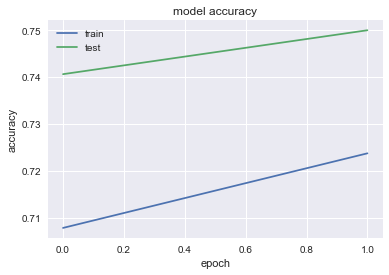

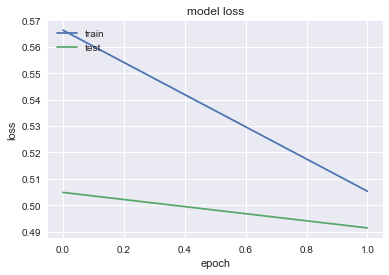

In [10]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
number_of_predictions = 59 # must not be greater than the number of test images in the directory
# predict label for a set of handpicked test images
testset_datagen = ImageDataGenerator(rescale=1./255)

testset_dir = data_dir + 'test'

testset_generator = testset_datagen.flow_from_directory(
        testset_dir,
        target_size=(rescaled_dim, rescaled_dim),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

In [ ]:
testset_predict = model.predict_generator(testset_generator, 40669)
classifier_threshold = 0.5 # TODO https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/discussion/32475
y_testset_predictions = (np.array(testset_predict) > classifier_threshold).astype(int)

In [ ]:
print ('time spent to complete execution:' , datetime.now() - startTime)